# Contrastive Learning with YOLOv8


Contrastive learning is motivated by the following question: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is SimCLR, which is visualized below (figure credit - Ting Chen et al.).

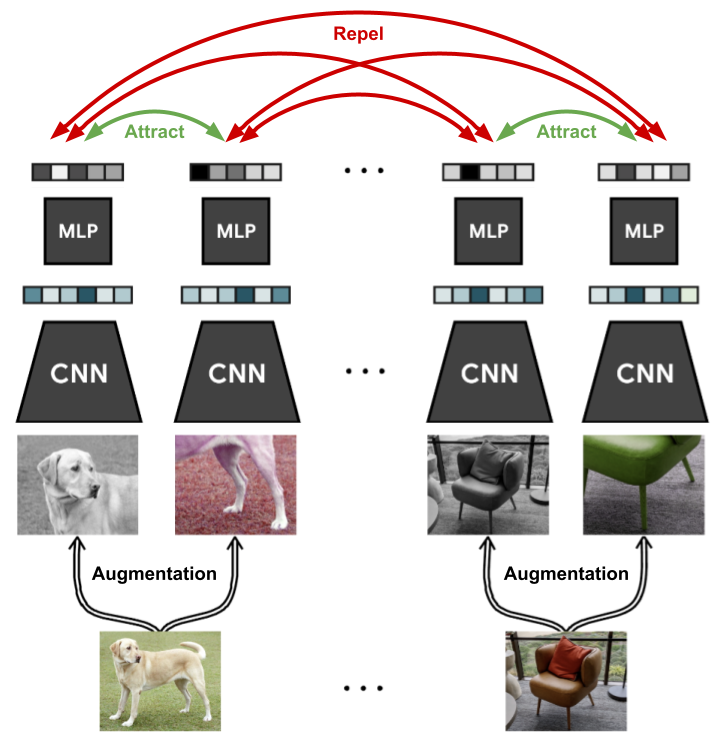


The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc.

On those images, we apply a CNN (in this case YOLOv8's backbone) and obtain as output a 1D feature vector on which we apply a small MLP. The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible. This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.


After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data.


---


### Libraries


In [ ]:
!pip install --quiet ultralytics
!pip install --quiet pytorch-lightning>=1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.7/644.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.io import read_image
from torchvision import transforms, models

## Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

## Ultralytics
import ultralytics
from ultralytics import YOLO

## other libraries
from PIL import Image
import cv2
import os
from copy import deepcopy
import matplotlib.pyplot as plt

## mount drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/Colab/Diplom/YoloSimclr"

# Path to the folder where the datasets are
DATASET_PATH = "/content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/images"

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO:lightning_fabric.utilities.seed:Global seed set to 42


### Custom CNN (YOLOv8 Backbone)


First, we have to build the YOLOv8 backbone from scratch. After adding the functionalities for each block used in the backbone, we can create a sequential model that contains these blocks in the order shown below:

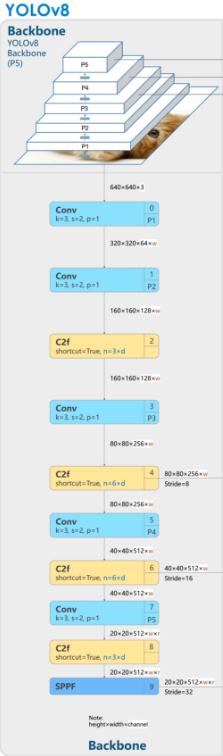


In [ ]:
## autopadding
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = (
            d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]
        )  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


## Conv block
class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""

    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(
            c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False
        )
        self.bn = nn.BatchNorm2d(c2)
        self.act = (
            self.default_act
            if act is True
            else act if isinstance(act, nn.Module) else nn.Identity()
        )

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Perform transposed convolution of 2D data."""
        return self.act(self.conv(x))


## Bottleneck
class Bottleneck(nn.Module):
    """Standard bottleneck."""

    def __init__(
        self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5
    ):  # ch_in, ch_out, shortcut, groups, kernels, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        """'forward()' applies the YOLOv5 FPN to input data."""
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


## C2f Block
class C2f(nn.Module):
    """CSP Bottleneck with 2 convolutions."""

    def __init__(
        self, c1, c2, n=1, shortcut=False, g=1, e=0.5
    ):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.ModuleList(
            Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0)
            for _ in range(n)
        )

    def forward(self, x):
        """Forward pass through C2f layer."""
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

    def forward_split(self, x):
        """Forward pass using split() instead of chunk()."""
        y = list(self.cv1(x).split((self.c, self.c), 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))


## SPPF Block
class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher."""

    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        """Forward pass through Ghost Convolution block."""
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)
        return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))

Now we can create the YOLOv8 backbone and use it as the encoder network and feature extractor. We can then create the projection network which is a simple sequential network. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, SimCLRv2, the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset.

The general setup is visualized below (figure credit - Ting Chen et al.):

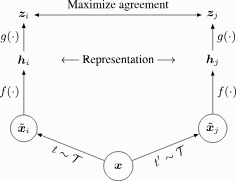


In [ ]:
## Encoder Network
encoder_model = nn.Sequential(
    Conv(3, 64, 3, 2),
    Conv(64, 128, 3, 2),
    C2f(128, 128, 3, True),
    Conv(128, 256, 3, 2),
    C2f(256, 256, 6, True),
    Conv(256, 512, 3, 2),
    C2f(512, 512, 6, True),
    Conv(512, 512, 3, 2),
    C2f(512, 512, 3, True),
    SPPF(512, 512, 5),
)

## Projection Head
# projection_head = nn.Sequential(
#           nn.Flatten(),
#           nn.Linear(in_features= 20 * 20 * 512, out_features=512),
#           nn.ReLU(inplace=True),
#           nn.Linear(in_features=4*hidden_dim, out_features= hidden_dim)
#         )

### Dataset


In [ ]:
## Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# root path of dataset folder
rootpath = "/content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/images"
# in case the data is stored in multiple
# folders, we append each subdir to the path list
paths = []

for subdir, dirs, files in os.walk(rootpath):
    for file in files:
        # print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        paths.append(filepath)


class DataClass(Dataset):
    def __init__(self, transform=None):
        self.list_of_paths = paths  # Here create a list of all image paths / paths..
        self.transform = transform

    def __len__(self):
        return len(self.list_of_paths)

    def __getitem__(self, x):
        imagepath = self.list_of_paths[x]  # Gives the path to an image
        image = Image.open(imagepath)  # Here load your image using your path
        if self.transform:
            image = self.transform(image)

        return image

### Data Augmentations for Contrastive Learning


To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.
This is implemented in the class ContrastiveTransformations below:


In [ ]:
class ContrastiveTransformations(object):
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more positive examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data. It turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by Ting Chen et al. in their SimCLR paper.

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize, color distortion, random grayscale, and gaussian blur. In comparison to the original implementation, we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue). In our experiments, this setting obtained better performance and was faster and more stable to train. If, for instance, the brightness scale highly varies in a dataset, the original settings can be more beneficial since the model can’t rely on this information anymore to distinguish between images.


In [ ]:
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.1, contrast=0.3, saturation=0.2, hue=0
                )
            ],
            p=0.3,
        ),
        transforms.RandomGrayscale(p=0.05),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
# instantiate dataset and apply the transformations
unlabeled_data = DataClass(
    transform=ContrastiveTransformations(contrast_transforms, n_views=2)
)

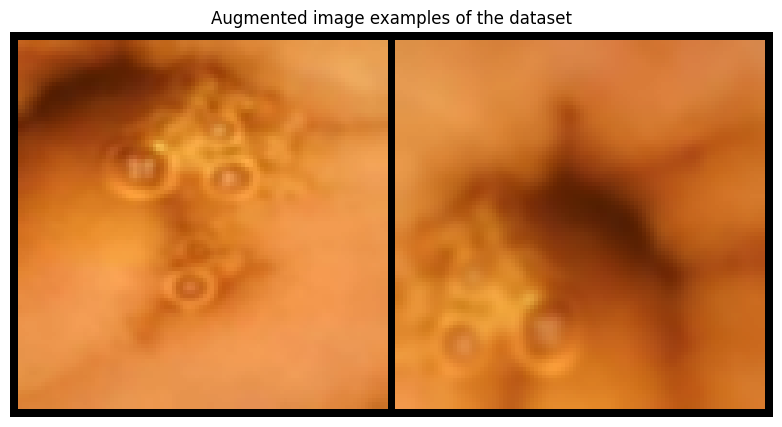

In [ ]:
NUM_IMAGES = 1
imgs = torch.stack(
    [img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx + 61]], dim=0
)
img_grid = torchvision.utils.make_grid(
    imgs, nrow=2, normalize=True, pad_value=0, scale_each=False
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the dataset")
plt.imshow(img_grid)
plt.axis("off")

plt.show()
plt.close()

### SimCLR implementation


After discussing the architecture, we implement SimCLR below as a PyTorch Lightning module:


In [ ]:
class YoloSimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert (
            self.hparams.temperature > 0.0
        ), "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = nn.Sequential(
            encoder_model,
            nn.Sequential(
                nn.Flatten(),
                nn.Linear(
                    in_features=3 * 3 * (4 * hidden_dim), out_features=4 * hidden_dim
                ),
                nn.ReLU(inplace=True),
                nn.Linear(in_features=4 * hidden_dim, out_features=hidden_dim),
            ),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [
                cos_sim[pos_mask][:, None],  # First position positive example
                cos_sim.masked_fill(pos_mask, -9e15),
            ],
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    # def validation_step(self, batch, batch_idx):
    #     self.info_nce_loss(batch, mode='val')

Here we implement the training procedure as it is described in the original SimCLR paper.


In [ ]:
def train_yolosimclr(batch_size, max_epochs=500, **kwargs):
    # Lightning Trainer
    trainer = pl.Trainer(
        default_root_dir=CHECKPOINT_PATH,
        accelerator="cuda",
        devices=1,
        max_epochs=max_epochs,
        log_every_n_steps=10,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, verbose=True),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._default_hp_metric = (
        None  # Optional logging argument that we don't need
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "YoloSimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = YoloSimCLR.load_from_checkpoint(
            pretrained_filename
        )  # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        # val_loader = DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
        #                              drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42)  # To be reproducable
        model = YoloSimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader)  # , val_loader
        model = YoloSimCLR.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    return model

After finishing the training with contrastive learning, we will remove the projection head and use YOLOv8 backbone as a pretrained feature extractor for a more complex object detection task.


---


In [ ]:
def verify_model(make_model, batch_size=1):
    # Input data
    data_loader = DataLoader(unlabeled_data, batch_size=batch_size)
    images = next(iter(data_loader))[0]

    # Model
    model = make_model
    model.to(device)

    # Forward pass
    model.eval()
    out = model(images.to(device))
    print(out.size())
    # probs = F.softmax(logits, dim=0)
    # preds = torch.argmax(probs, dim=1)

    return

In [ ]:
hidden_dim = 128
full_model = nn.Sequential(
    encoder_model,
    nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=3 * 3 * (4 * hidden_dim), out_features=4 * hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=4 * hidden_dim, out_features=hidden_dim),
    ),
)

verify_model(full_model)

torch.Size([1, 128])


In [ ]:
# Experimentation with hyperparameters.

simclr_model = train_yolosimclr(
    batch_size=128,
    lr=5e-4,
    hidden_dim=128,
    temperature=0.07,
    weight_decay=1e-4,
    max_epochs=10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | convnet | Sequential | 22.2 M
---------------------------------------
22.2 M    Trainable params
0         Non-trainable params
22.2 M    Total params
88.936    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
from ultralytics.nn.tasks import attempt_load_weights


def intersect_dicts(da, db, exclude=()):
    return {
        k: v
        for k, v in da.items()
        if k in db and not any(x in k for x in exclude) and v.shape == db[k].shape
    }


model = attempt_load_weights("yolov8l.pt")
ckpt = torch.load(
    "/content/drive/MyDrive/Colab/Diplom/YoloSimclr/lightning_logs/version_4/checkpoints/epoch=1-step=46.ckpt",
    weights_only=False,
)
new_ckpt = {
    key.replace("convnet.0", "model"): value
    for key, value in ckpt["state_dict"].items()
}
intersect = intersect_dicts(new_ckpt, model.state_dict())

print(intersect.keys())

print(model.state_dict().keys())
print("\n")
print(new_ckpt.keys())
model.load_state_dict(intersect, strict=False)
torch.save(model, "simclr_weights.pt")

# model.train(**{'cfg': '/ultralytics/yolo/cfg/train.yaml'})

100%|██████████| 83.7M/83.7M [00:01<00:00, 73.2MB/s]


dict_keys(['model.0.conv.weight', 'model.0.bn.weight', 'model.0.bn.bias', 'model.0.bn.running_mean', 'model.0.bn.running_var', 'model.0.bn.num_batches_tracked', 'model.1.conv.weight', 'model.1.bn.weight', 'model.1.bn.bias', 'model.1.bn.running_mean', 'model.1.bn.running_var', 'model.1.bn.num_batches_tracked', 'model.2.cv1.conv.weight', 'model.2.cv1.bn.weight', 'model.2.cv1.bn.bias', 'model.2.cv1.bn.running_mean', 'model.2.cv1.bn.running_var', 'model.2.cv1.bn.num_batches_tracked', 'model.2.cv2.conv.weight', 'model.2.cv2.bn.weight', 'model.2.cv2.bn.bias', 'model.2.cv2.bn.running_mean', 'model.2.cv2.bn.running_var', 'model.2.cv2.bn.num_batches_tracked', 'model.2.m.0.cv1.conv.weight', 'model.2.m.0.cv1.bn.weight', 'model.2.m.0.cv1.bn.bias', 'model.2.m.0.cv1.bn.running_mean', 'model.2.m.0.cv1.bn.running_var', 'model.2.m.0.cv1.bn.num_batches_tracked', 'model.2.m.0.cv2.conv.weight', 'model.2.m.0.cv2.bn.weight', 'model.2.m.0.cv2.bn.bias', 'model.2.m.0.cv2.bn.running_mean', 'model.2.m.0.cv2.bn.r

In [ ]:
# model_yolo = YOLO('yolov8l.yaml').load('yolov8l.pt')

model1 = torch.load("yolov8l.pt")
print(model1.keys())
model2 = torch.load("simclr_weights.pt")
model1["model"] = model2


torch.save(model1, "new_simclr_weights.pt")

dict_keys(['epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args', 'date', 'version'])


In [ ]:
model_yolo = YOLO("new_simclr_weights.pt")
model_yolo.train(
    data="/content/drive/MyDrive/Colab/Diplom/KVASIR/data.yaml",
    batch=64,
    epochs=2,
    lr0=0.000001,
    lrf=0.01,
    patience=10,
    pretrained=True,
    device=0,
    workers=20,
    val=False,
    imgsz=336,
    optimizer="Adam",
    verbose=False,
    name="run_name1",
)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=new_simclr_weights.pt, data=/content/drive/MyDrive/Colab/Diplom/KVASIR/data.yaml, epochs=2, patience=10, batch=64, imgsz=336, save=True, save_period=-1, cache=False, device=0, workers=20, project=None, name=run_name1, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tru

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4ad070dbd0>
fitness: 7.837928815752917e-06
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([ 9.9962e-06,           0])
names: {0: 'Red', 1: 'White'}
plot: True
results_dict: {'metrics/precision(B)': 6.564264145989234e-05, 'metrics/recall(B)': 0.00625, 'metrics/mAP50(B)': 3.339645477564412e-05, 'metrics/mAP50-95(B)': 4.998092597987227e-06, 'fitness': 7.837928815752917e-06}
save_dir: PosixPath('runs/detect/run_name1')
speed: {'preprocess': 0.0686591881507637, 'inference': 5.40422793429361, 'loss': 0.00028453720128365415, 'postprocess': 1.2500591970848585}

In [ ]:
model_inf = YOLO("/content/runs/detect/run_name1/weights/best.pt")
metrics = model_inf.val(save_txt=True)
print(metrics)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43608150 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/val/labels.cache... 6001 images, 5632 backgrounds, 0 corrupt: 100%|██████████| 6002/6002 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 376/376 [01:38<00:00,  3.81it/s]
                   all       6002        370   6.54e-05    0.00625   3.33e-05   4.98e-06
                   Red       6002        160   0.000131     0.0125   6.66e-05   9.96e-06
                 White       6002        210          0          0          0          0
Speed: 0.1ms preprocess, 12.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4aec78dea0>
fitness: 7.809921203860788e-06
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([ 9.9603e-06,           0])
names: {0: 'Red', 1: 'White'}
plot: True
results_dict: {'metrics/precision(B)': 6.540222367560497e-05, 'metrics/recall(B)': 0.00625, 'metrics/mAP50(B)': 3.3277734846126386e-05, 'metrics/mAP50-95(B)': 4.980164132497944e-06, 'fitness': 7.809921203860788e-06}
save_dir: PosixPath('runs/detect/val2')
speed: {'preprocess': 0.10985412108266565, 'inference': 12.002671928812527, 'loss': 0.0013541635057601241, 'postprocess': 0.8757753556507979}


In [ ]:
metrics

In [ ]:
model_yolo = YOLO("yolov8l.pt")
model_yolo.train(
    data="/content/drive/MyDrive/Colab/Diplom/KVASIR/data.yaml",
    batch=64,
    epochs=2,
    lr0=0.000001,
    lrf=0.01,
    patience=10,
    pretrained=True,
    device=0,
    workers=20,
    val=False,
    imgsz=336,
    optimizer="Adam",
    verbose=False,
    name="run_name2",
)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/Colab/Diplom/KVASIR/data.yaml, epochs=2, patience=10, batch=64, imgsz=336, save=True, save_period=-1, cache=False, device=0, workers=20, project=None, name=run_name2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=t

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa3b8e96200>
fitness: 0.033444604910865774
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([  0.0086789,    0.049779])
names: {0: 'Red', 1: 'White'}
plot: True
results_dict: {'metrics/precision(B)': 0.14893374418324246, 'metrics/recall(B)': 0.0888392857142857, 'metrics/mAP50(B)': 0.07138397595568438, 'metrics/mAP50-95(B)': 0.029229119239219264, 'fitness': 0.033444604910865774}
save_dir: PosixPath('runs/detect/run_name2')
speed: {'preprocess': 0.19991076099836838, 'inference': 4.901761056899389, 'loss': 0.00028719865493240536, 'postprocess': 1.251697738899147}

In [ ]:
# Pt = False
model1 = attempt_load_weights("yolov8l.pt")
# print(model1.keys())
print(model1.state_dict())

In [ ]:
# Pt = True
model1 = attempt_load_weights("new_simclr_weights.pt")
print(model1.state_dict())

In [ ]:
model = YOLO("/content/runs/detect/run_name1/weights/best.pt")

results = model.predict(
    source="/content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/images",
    conf=0.01,
    iou=0.5,
    plots=True,
    device=0,
    imgsz=336,
    batch=128,
    max_det=1,
    save_conf=True,
    save_txt=True,
)


WARNING ⚠️ imgsz=[336] must be multiple of max stride 32, updating to [352]

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3065 /content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/images/0728084c8da942d9_10952.jpg: 352x352 1 White, 36.5ms
image 2/3065 /content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/images/0728084c8da942d9_10968.jpg: 352x352 (no detections), 30.6ms
image 3/3065 /content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/images/0728084c8da942d9_10972.jpg: 352x352 (

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

---
---

---

---


In [ ]:
ids = [
    "ad91cf7ca91440aa_4753",
    "5e59c7fdb16c4228_26129",
    "5e59c7fdb16c4228_32337",
    "2fc3db471f9d44c0_2541",
    "64440803f87b4843_17850",
]
imgs = [id + ".jpg" for id in ids]
bbxs = [id + ".txt" for id in ids]

for dirpath, dirnames, filenames in os.walk(
    "/content/drive/MyDrive/Colab/Diplom/KVASIR/dataset"
):
    for filename in filenames:
        if filename in imgs:
            path_to_img = dirpath + "/" + filename
            path_to_txt = (
                dirpath.replace("images", "labels")
                + "/"
                + filename.replace(".jpg", ".txt")
            )

            with open(path_to_txt, "r") as f:
                line = f.readline()

            image = cv2.imread(path_to_img)
            bb = line.split(" ")
            bounding_box = {
                "class": bb[0],
                "x_center": float(bb[1]),
                "y_center": float(bb[2]),
                "width": float(bb[3]),
                "height": float(bb[4]),
            }

            x0 = 336 * bounding_box["x_center"] - 336 * bounding_box["width"] / 2
            x1 = 336 * bounding_box["x_center"] + 336 * bounding_box["width"] / 2
            y0 = 336 * bounding_box["y_center"] - 336 * bounding_box["height"] / 2
            y1 = 336 * bounding_box["y_center"] + 336 * bounding_box["height"] / 2

            start_point = (int(x0), int(y0))
            end_point = (int(x1), int(y1))

            if int(bounding_box["class"]) == 0:
                class_txt = "Red"
                cv2.rectangle(
                    image, start_point, end_point, color=(0, 0, 255), thickness=2
                )
                class_color = ()
            elif int(bounding_box["class"]) == 1:
                class_txt = "White"
                class_color = ()
                cv2.rectangle(
                    image, start_point, end_point, color=(0, 255, 0), thickness=2
                )

            cv2.putText(
                image,
                class_txt,
                org=(int(x0), int(y0) - 3),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.6,
                color=(255, 255, 255),
                thickness=1,
            )

            cv2.imwrite(filename.replace(".jpg", "") + "_bb.jpg", image)

In [ ]:
erosion_n = [
    "0728084c8da942d9_29983.txt",
    "0728084c8da942d9_29984.txt",
    "0728084c8da942d9_29985.txt",
    "0728084c8da942d9_29986.txt",
    "0728084c8da942d9_29987.txt",
    "0728084c8da942d9_29988.txt",
    "0728084c8da942d9_29989.txt",
    "0728084c8da942d9_29990.txt",
    "0728084c8da942d9_29991.txt",
    "0728084c8da942d9_29992.txt",
    "0728084c8da942d9_29993.txt",
    "0728084c8da942d9_29994.txt",
    "0728084c8da942d9_29995.txt",
    "0728084c8da942d9_29996.txt",
    "0728084c8da942d9_29997.txt",
    "0728084c8da942d9_29998.txt",
    "0728084c8da942d9_28920.txt",
    "0728084c8da942d9_28921.txt",
    "0728084c8da942d9_28922.txt",
    "0728084c8da942d9_28923.txt",
    "0728084c8da942d9_28924.txt",
    "0728084c8da942d9_28925.txt",
    "0728084c8da942d9_28926.txt",
    "0728084c8da942d9_28927.txt",
    "0728084c8da942d9_28786.txt",
    "0728084c8da942d9_28787.txt",
    "0728084c8da942d9_28788.txt",
    "0728084c8da942d9_28789.txt",
    "0728084c8da942d9_28798.txt",
    "0728084c8da942d9_28799.txt",
    "0728084c8da942d9_28800.txt",
    "0728084c8da942d9_28738.txt",
    "0728084c8da942d9_28739.txt",
    "0728084c8da942d9_28740.txt",
    "0728084c8da942d9_28741.txt",
    "0728084c8da942d9_28742.txt",
    "0728084c8da942d9_28743.txt",
    "0728084c8da942d9_28744.txt",
    "0728084c8da942d9_28745.txt",
    "0728084c8da942d9_28746.txt",
    "0728084c8da942d9_28747.txt",
    "0728084c8da942d9_28748.txt",
    "0728084c8da942d9_28749.txt",
    "0728084c8da942d9_28750.txt",
    "0728084c8da942d9_28751.txt",
    "0728084c8da942d9_28752.txt",
    "0728084c8da942d9_28753.txt",
    "0728084c8da942d9_28754.txt",
    "0728084c8da942d9_28757.txt",
    "0728084c8da942d9_28758.txt",
    "0728084c8da942d9_28759.txt",
    "0728084c8da942d9_28760.txt",
    "0728084c8da942d9_28761.txt",
    "0728084c8da942d9_28762.txt",
    "0728084c8da942d9_28763.txt",
    "0728084c8da942d9_28764.txt",
    "0728084c8da942d9_28765.txt",
    "0728084c8da942d9_28686.txt",
    "0728084c8da942d9_28687.txt",
    "0728084c8da942d9_28688.txt",
    "0728084c8da942d9_28689.txt",
    "0728084c8da942d9_28690.txt",
    "0728084c8da942d9_28691.txt",
    "0728084c8da942d9_28692.txt",
    "0728084c8da942d9_28693.txt",
    "0728084c8da942d9_28694.txt",
    "0728084c8da942d9_28695.txt",
    "0728084c8da942d9_28696.txt",
    "0728084c8da942d9_28697.txt",
    "0728084c8da942d9_28698.txt",
    "0728084c8da942d9_28699.txt",
    "0728084c8da942d9_28700.txt",
    "0728084c8da942d9_27175.txt",
    "0728084c8da942d9_27176.txt",
    "0728084c8da942d9_27177.txt",
    "0728084c8da942d9_27178.txt",
    "0728084c8da942d9_27118.txt",
    "0728084c8da942d9_27119.txt",
    "0728084c8da942d9_27120.txt",
    "0728084c8da942d9_27121.txt",
    "0728084c8da942d9_27122.txt",
    "dac1e27f7e4d4ef5_3381.txt",
    "dac1e27f7e4d4ef5_3382.txt",
    "dac1e27f7e4d4ef5_3383.txt",
    "dac1e27f7e4d4ef5_3385.txt",
    "dac1e27f7e4d4ef5_3386.txt",
    "dac1e27f7e4d4ef5_3387.txt",
    "dac1e27f7e4d4ef5_3391.txt",
    "dac1e27f7e4d4ef5_3392.txt",
    "dac1e27f7e4d4ef5_3393.txt",
    "dac1e27f7e4d4ef5_3395.txt",
    "dac1e27f7e4d4ef5_3396.txt",
    "dac1e27f7e4d4ef5_3397.txt",
    "dac1e27f7e4d4ef5_3398.txt",
    "dac1e27f7e4d4ef5_3399.txt",
    "dac1e27f7e4d4ef5_3400.txt",
    "dac1e27f7e4d4ef5_3401.txt",
    "dac1e27f7e4d4ef5_3402.txt",
    "dac1e27f7e4d4ef5_3403.txt",
    "dac1e27f7e4d4ef5_3404.txt",
    "dac1e27f7e4d4ef5_3405.txt",
    "dac1e27f7e4d4ef5_3406.txt",
    "dac1e27f7e4d4ef5_3407.txt",
    "dac1e27f7e4d4ef5_3408.txt",
    "dac1e27f7e4d4ef5_2927.txt",
    "dac1e27f7e4d4ef5_2928.txt",
    "dac1e27f7e4d4ef5_2929.txt",
    "dac1e27f7e4d4ef5_2930.txt",
    "dac1e27f7e4d4ef5_2931.txt",
    "dac1e27f7e4d4ef5_2397.txt",
    "dac1e27f7e4d4ef5_2399.txt",
    "dac1e27f7e4d4ef5_2400.txt",
    "dac1e27f7e4d4ef5_2401.txt",
    "dac1e27f7e4d4ef5_1755.txt",
    "dac1e27f7e4d4ef5_1756.txt",
    "dac1e27f7e4d4ef5_1757.txt",
    "dac1e27f7e4d4ef5_1728.txt",
    "eb0203196e284797_1125.txt",
    "eb0203196e284797_1126.txt",
    "eb0203196e284797_1130.txt",
    "eb0203196e284797_1131.txt",
    "eb0203196e284797_1135.txt",
    "eb0203196e284797_1136.txt",
    "eb0203196e284797_1137.txt",
    "eb0203196e284797_9023.txt",
    "eb0203196e284797_6173.txt",
    "eb0203196e284797_6174.txt",
    "eb0203196e284797_6175.txt",
    "eb0203196e284797_6176.txt",
    "eb0203196e284797_6177.txt",
    "eb0203196e284797_6178.txt",
    "eb0203196e284797_6179.txt",
    "eb0203196e284797_6180.txt",
    "eb0203196e284797_6181.txt",
    "eb0203196e284797_6182.txt",
    "eb0203196e284797_6183.txt",
    "eb0203196e284797_6184.txt",
    "eb0203196e284797_6185.txt",
    "eb0203196e284797_6186.txt",
    "eb0203196e284797_6187.txt",
    "eb0203196e284797_6188.txt",
    "eb0203196e284797_6189.txt",
    "eb0203196e284797_6190.txt",
    "eb0203196e284797_6191.txt",
    "eb0203196e284797_6192.txt",
    "eb0203196e284797_6193.txt",
    "eb0203196e284797_6194.txt",
    "eb0203196e284797_6195.txt",
    "eb0203196e284797_6201.txt",
    "eb0203196e284797_6202.txt",
    "eb0203196e284797_6203.txt",
    "eb0203196e284797_6204.txt",
    "eb0203196e284797_6205.txt",
    "eb0203196e284797_6206.txt",
    "eb0203196e284797_6207.txt",
    "eb0203196e284797_6244.txt",
    "eb0203196e284797_6252.txt",
    "eb0203196e284797_6253.txt",
    "eb0203196e284797_6254.txt",
    "eb0203196e284797_6255.txt",
    "eb0203196e284797_6256.txt",
    "eb0203196e284797_6257.txt",
    "eb0203196e284797_6258.txt",
    "eb0203196e284797_6259.txt",
    "eb0203196e284797_6260.txt",
    "eb0203196e284797_6261.txt",
    "eb0203196e284797_6262.txt",
    "eb0203196e284797_2380.txt",
    "eb0203196e284797_2379.txt",
    "eb0203196e284797_2380.txt",
    "eb0203196e284797_2339.txt",
    "eb0203196e284797_2340.txt",
    "5e59c7fdb16c4228_38470.txt",
    "5e59c7fdb16c4228_38471.txt",
    "5e59c7fdb16c4228_38472.txt",
    "5e59c7fdb16c4228_38473.txt",
    "5e59c7fdb16c4228_38474.txt",
    "5e59c7fdb16c4228_38475.txt",
    "5e59c7fdb16c4228_38476.txt",
    "5e59c7fdb16c4228_38477.txt",
    "5e59c7fdb16c4228_38262.txt",
    "5e59c7fdb16c4228_38263.txt",
    "5e59c7fdb16c4228_38264.txt",
    "5e59c7fdb16c4228_38265.txt",
    "5e59c7fdb16c4228_38266.txt",
    "5e59c7fdb16c4228_37513.txt",
    "5e59c7fdb16c4228_37514.txt",
    "5e59c7fdb16c4228_37701.txt",
    "5e59c7fdb16c4228_37750.txt",
    "5e59c7fdb16c4228_37751.txt",
    "5e59c7fdb16c4228_37752.txt",
    "5e59c7fdb16c4228_37753.txt",
    "5e59c7fdb16c4228_37765.txt",
    "5e59c7fdb16c4228_37766.txt",
    "5e59c7fdb16c4228_37767.txt",
    "5e59c7fdb16c4228_37907.txt",
    "5e59c7fdb16c4228_36151.txt",
    "5e59c7fdb16c4228_36152.txt",
    "5e59c7fdb16c4228_36153.txt",
    "5e59c7fdb16c4228_32325.txt",
    "5e59c7fdb16c4228_32326.txt",
    "5e59c7fdb16c4228_32335.txt",
    "5e59c7fdb16c4228_32336.txt",
    "5e59c7fdb16c4228_32337.txt",
    "8ebf0e483cac48d6_29687.txt",
    "8ebf0e483cac48d6_29688.txt",
    "8ebf0e483cac48d6_29550.txt",
    "8ebf0e483cac48d6_29551.txt",
    "8ebf0e483cac48d6_29552.txt",
    "8ebf0e483cac48d6_29553.txt",
    "8ebf0e483cac48d6_29554.txt",
    "8ebf0e483cac48d6_29555.txt",
    "8ebf0e483cac48d6_29556.txt",
    "8ebf0e483cac48d6_29557.txt",
    "8ebf0e483cac48d6_29558.txt",
    "8ebf0e483cac48d6_29559.txt",
    "8ebf0e483cac48d6_29560.txt",
    "8ebf0e483cac48d6_29532.txt",
    "8ebf0e483cac48d6_29533.txt",
    "8ebf0e483cac48d6_29534.txt",
    "8ebf0e483cac48d6_29535.txt",
    "8ebf0e483cac48d6_29536.txt",
    "8ebf0e483cac48d6_29537.txt",
    "8ebf0e483cac48d6_29538.txt",
    "8ebf0e483cac48d6_29539.txt",
    "8ebf0e483cac48d6_29540.txt",
    "8ebf0e483cac48d6_29541.txt",
    "8ebf0e483cac48d6_29197.txt",
    "8ebf0e483cac48d6_29198.txt",
    "8ebf0e483cac48d6_29199.txt",
    "8ebf0e483cac48d6_29200.txt",
    "8ebf0e483cac48d6_29201.txt",
    "8ebf0e483cac48d6_29202.txt",
    "8ebf0e483cac48d6_29203.txt",
    "8ebf0e483cac48d6_29204.txt",
    "8ebf0e483cac48d6_29205.txt",
    "8ebf0e483cac48d6_29206.txt",
    "8ebf0e483cac48d6_29207.txt",
    "8ebf0e483cac48d6_29208.txt",
    "8ebf0e483cac48d6_29209.txt",
    "8ebf0e483cac48d6_29210.txt",
    "8ebf0e483cac48d6_29211.txt",
    "8ebf0e483cac48d6_29212.txt",
    "8ebf0e483cac48d6_29213.txt",
    "8ebf0e483cac48d6_29214.txt",
    "8ebf0e483cac48d6_29215.txt",
    "8ebf0e483cac48d6_29216.txt",
    "8ebf0e483cac48d6_29217.txt",
    "8ebf0e483cac48d6_21586.txt",
    "8ebf0e483cac48d6_21587.txt",
    "8ebf0e483cac48d6_21588.txt",
    "8ebf0e483cac48d6_13419.txt",
    "8ebf0e483cac48d6_13420.txt",
    "8ebf0e483cac48d6_13421.txt",
    "8ebf0e483cac48d6_13422.txt",
    "8ebf0e483cac48d6_13423.txt",
    "8ebf0e483cac48d6_13424.txt",
    "8ebf0e483cac48d6_13425.txt",
    "8ebf0e483cac48d6_13426.txt",
    "8ebf0e483cac48d6_13427.txt",
    "8ebf0e483cac48d6_13428.txt",
    "8ebf0e483cac48d6_13429.txt",
    "8ebf0e483cac48d6_13430.txt",
    "8ebf0e483cac48d6_13431.txt",
    "8ebf0e483cac48d6_13432.txt",
    "8ebf0e483cac48d6_13433.txt",
    "8ebf0e483cac48d6_13434.txt",
    "8ebf0e483cac48d6_13435.txt",
    "8ebf0e483cac48d6_13436.txt",
    "8ebf0e483cac48d6_13437.txt",
    "8ebf0e483cac48d6_13438.txt",
    "8ebf0e483cac48d6_13439.txt",
    "8ebf0e483cac48d6_13440.txt",
    "8ebf0e483cac48d6_13441.txt",
    "8ebf0e483cac48d6_13442.txt",
    "8ebf0e483cac48d6_13443.txt",
    "8ebf0e483cac48d6_13444.txt",
    "8ebf0e483cac48d6_13445.txt",
    "8ebf0e483cac48d6_13446.txt",
    "8ebf0e483cac48d6_13447.txt",
    "8ebf0e483cac48d6_13448.txt",
    "8ebf0e483cac48d6_13449.txt",
    "8ebf0e483cac48d6_13450.txt",
    "8ebf0e483cac48d6_13451.txt",
    "8ebf0e483cac48d6_13452.txt",
    "8ebf0e483cac48d6_13453.txt",
    "8ebf0e483cac48d6_13454.txt",
    "8ebf0e483cac48d6_13455.txt",
    "8ebf0e483cac48d6_13456.txt",
    "8ebf0e483cac48d6_13457.txt",
    "8ebf0e483cac48d6_13458.txt",
    "8ebf0e483cac48d6_13459.txt",
    "8ebf0e483cac48d6_13460.txt",
    "8ebf0e483cac48d6_13461.txt",
    "8ebf0e483cac48d6_13462.txt",
    "8ebf0e483cac48d6_13463.txt",
    "8ebf0e483cac48d6_13464.txt",
    "8ebf0e483cac48d6_13465.txt",
    "8ebf0e483cac48d6_13466.txt",
    "8ebf0e483cac48d6_13467.txt",
    "8ebf0e483cac48d6_13468.txt",
    "8ebf0e483cac48d6_13469.txt",
    "8ebf0e483cac48d6_13470.txt",
    "8ebf0e483cac48d6_13471.txt",
    "8ebf0e483cac48d6_13472.txt",
    "8ebf0e483cac48d6_13473.txt",
    "8ebf0e483cac48d6_13474.txt",
    "8ebf0e483cac48d6_13475.txt",
    "8ebf0e483cac48d6_13476.txt",
    "8ebf0e483cac48d6_13477.txt",
    "8ebf0e483cac48d6_11667.txt",
    "8ebf0e483cac48d6_11668.txt",
    "8ebf0e483cac48d6_11669.txt",
    "8ebf0e483cac48d6_11670.txt",
    "8ebf0e483cac48d6_11671.txt",
    "8ebf0e483cac48d6_11672.txt",
    "8ebf0e483cac48d6_11673.txt",
    "8ebf0e483cac48d6_11674.txt",
    "8ebf0e483cac48d6_11675.txt",
    "8ebf0e483cac48d6_11676.txt",
    "8ebf0e483cac48d6_11677.txt",
    "8ebf0e483cac48d6_11678.txt",
    "8ebf0e483cac48d6_11679.txt",
    "8ebf0e483cac48d6_11680.txt",
    "8ebf0e483cac48d6_11681.txt",
    "8ebf0e483cac48d6_11682.txt",
    "8ebf0e483cac48d6_11683.txt",
    "8ebf0e483cac48d6_11684.txt",
    "8ebf0e483cac48d6_11685.txt",
    "8ebf0e483cac48d6_11686.txt",
    "8ebf0e483cac48d6_11687.txt",
    "8ebf0e483cac48d6_11688.txt",
    "8ebf0e483cac48d6_11689.txt",
    "8ebf0e483cac48d6_11690.txt",
    "8ebf0e483cac48d6_11691.txt",
    "8ebf0e483cac48d6_11692.txt",
    "8ebf0e483cac48d6_11693.txt",
    "8ebf0e483cac48d6_11694.txt",
    "8ebf0e483cac48d6_11695.txt",
    "8ebf0e483cac48d6_11696.txt",
    "8ebf0e483cac48d6_11697.txt",
    "8ebf0e483cac48d6_11698.txt",
    "8ebf0e483cac48d6_11699.txt",
    "8ebf0e483cac48d6_11700.txt",
    "8ebf0e483cac48d6_11701.txt",
    "8ebf0e483cac48d6_11702.txt",
    "8ebf0e483cac48d6_11703.txt",
    "8ebf0e483cac48d6_11704.txt",
    "bca26705313a4644_20401.txt",
    "bca26705313a4644_20402.txt",
    "bca26705313a4644_20403.txt",
    "bca26705313a4644_20404.txt",
    "bca26705313a4644_18110.txt",
    "bca26705313a4644_18111.txt",
    "bca26705313a4644_18129.txt",
    "bca26705313a4644_18130.txt",
    "bca26705313a4644_18131.txt",
    "bca26705313a4644_18132.txt",
    "bca26705313a4644_18133.txt",
    "bca26705313a4644_18134.txt",
    "bca26705313a4644_18163.txt",
    "bca26705313a4644_18164.txt",
    "bca26705313a4644_18165.txt",
    "bca26705313a4644_18166.txt",
    "bca26705313a4644_18179.txt",
    "bca26705313a4644_18180.txt",
    "bca26705313a4644_18189.txt",
    "bca26705313a4644_18190.txt",
    "bca26705313a4644_18191.txt",
    "bca26705313a4644_18065.txt",
    "bca26705313a4644_18066.txt",
    "bca26705313a4644_18067.txt",
    "bca26705313a4644_16391.txt",
    "bca26705313a4644_16392.txt",
    "bca26705313a4644_16394.txt",
    "bca26705313a4644_16395.txt",
    "bca26705313a4644_16396.txt",
    "bca26705313a4644_16397.txt",
    "bca26705313a4644_16399.txt",
    "bca26705313a4644_16400.txt",
    "bca26705313a4644_16404.txt",
    "bca26705313a4644_16405.txt",
    "bca26705313a4644_16406.txt",
    "bca26705313a4644_16407.txt",
    "bca26705313a4644_16138.txt",
    "bca26705313a4644_16139.txt",
    "bca26705313a4644_16140.txt",
    "bca26705313a4644_16141.txt",
    "bca26705313a4644_16142.txt",
    "bca26705313a4644_16145.txt",
    "bca26705313a4644_16146.txt",
    "bca26705313a4644_16147.txt",
    "bca26705313a4644_16148.txt",
    "bca26705313a4644_16152.txt",
    "bca26705313a4644_16153.txt",
    "bca26705313a4644_16154.txt",
    "bca26705313a4644_16164.txt",
    "bca26705313a4644_16165.txt",
    "bca26705313a4644_16166.txt",
    "bca26705313a4644_16167.txt",
    "bca26705313a4644_16168.txt",
    "bca26705313a4644_16169.txt",
    "bca26705313a4644_16170.txt",
    "bca26705313a4644_16171.txt",
    "bca26705313a4644_16172.txt",
    "bca26705313a4644_16173.txt",
    "bca26705313a4644_16174.txt",
    "bca26705313a4644_16010.txt",
    "bca26705313a4644_16011.txt",
    "bca26705313a4644_16012.txt",
    "bca26705313a4644_16049.txt",
    "bca26705313a4644_16050.txt",
    "bca26705313a4644_16051.txt",
    "bca26705313a4644_16052.txt",
    "bca26705313a4644_16053.txt",
    "bca26705313a4644_16060.txt",
    "bca26705313a4644_16061.txt",
    "bca26705313a4644_16062.txt",
    "bca26705313a4644_16073.txt",
    "bca26705313a4644_16074.txt",
    "d626f4f4a5ac4785_50178.txt",
    "d626f4f4a5ac4785_50179.txt",
    "d626f4f4a5ac4785_50180.txt",
    "d626f4f4a5ac4785_50181.txt",
    "d626f4f4a5ac4785_50182.txt",
    "d626f4f4a5ac4785_50183.txt",
    "d626f4f4a5ac4785_50195.txt",
    "d626f4f4a5ac4785_50196.txt",
    "d626f4f4a5ac4785_50200.txt",
    "d626f4f4a5ac4785_50201.txt",
    "d626f4f4a5ac4785_50202.txt",
    "d626f4f4a5ac4785_50203.txt",
    "d626f4f4a5ac4785_50227.txt",
    "d626f4f4a5ac4785_50228.txt",
    "d626f4f4a5ac4785_50230.txt",
    "d626f4f4a5ac4785_50120.txt",
    "d626f4f4a5ac4785_50040.txt",
    "d626f4f4a5ac4785_50041.txt",
    "d626f4f4a5ac4785_50054.txt",
    "d626f4f4a5ac4785_50055.txt",
    "d626f4f4a5ac4785_50056.txt",
    "d626f4f4a5ac4785_50057.txt",
    "d626f4f4a5ac4785_50058.txt",
    "d626f4f4a5ac4785_50084.txt",
    "d626f4f4a5ac4785_50085.txt",
    "d626f4f4a5ac4785_50086.txt",
    "d626f4f4a5ac4785_50090.txt",
    "d626f4f4a5ac4785_50091.txt",
    "d626f4f4a5ac4785_50092.txt",
    "d626f4f4a5ac4785_50093.txt",
    "d626f4f4a5ac4785_50094.txt",
    "d626f4f4a5ac4785_50108.txt",
    "d626f4f4a5ac4785_13420.txt",
    "d626f4f4a5ac4785_13421.txt",
    "d626f4f4a5ac4785_13422.txt",
    "d626f4f4a5ac4785_13423.txt",
    "d626f4f4a5ac4785_13424.txt",
    "d626f4f4a5ac4785_13425.txt",
    "d626f4f4a5ac4785_13426.txt",
    "0531325b64674948_232.txt",
    "0531325b64674948_233.txt",
    "0531325b64674948_234.txt",
    "0531325b64674948_235.txt",
    "0531325b64674948_236.txt",
    "0531325b64674948_237.txt",
    "0531325b64674948_238.txt",
    "0531325b64674948_239.txt",
    "0531325b64674948_240.txt",
    "0531325b64674948_241.txt",
    "0531325b64674948_242.txt",
    "0531325b64674948_243.txt",
    "0531325b64674948_244.txt",
    "0531325b64674948_245.txt",
    "0531325b64674948_246.txt",
    "0531325b64674948_248.txt",
    "fb86bc87d3874cd7_3660.txt",
    "fb86bc87d3874cd7_724.txt",
    "fb86bc87d3874cd7_725.txt",
    "fb86bc87d3874cd7_726.txt",
    "fb86bc87d3874cd7_727.txt",
    "fb86bc87d3874cd7_728.txt",
    "fb86bc87d3874cd7_729.txt",
    "fb86bc87d3874cd7_730.txt",
    "fb86bc87d3874cd7_731.txt",
    "fb86bc87d3874cd7_732.txt",
    "fb86bc87d3874cd7_734.txt",
    "fb86bc87d3874cd7_674.txt",
    "fb86bc87d3874cd7_675.txt",
    "fb86bc87d3874cd7_676.txt",
    "fb86bc87d3874cd7_677.txt",
    "fb86bc87d3874cd7_682.txt",
    "fb86bc87d3874cd7_683.txt",
    "fb86bc87d3874cd7_685.txt",
    "fb86bc87d3874cd7_686.txt",
    "fb86bc87d3874cd7_687.txt",
    "fb86bc87d3874cd7_688.txt",
    "fb86bc87d3874cd7_689.txt",
    "fb86bc87d3874cd7_451.txt",
    "fb86bc87d3874cd7_453.txt",
    "fb86bc87d3874cd7_454.txt",
    "fb86bc87d3874cd7_356.txt",
    "fb86bc87d3874cd7_357.txt",
    "fb86bc87d3874cd7_358.txt",
    "fb86bc87d3874cd7_360.txt",
    "fb86bc87d3874cd7_361.txt",
    "fb86bc87d3874cd7_362.txt",
    "fb86bc87d3874cd7_363.txt",
]

erythema_n = [
    "5e59c7fdb16c4228_35608.txt",
    "5e59c7fdb16c4228_35609.txt",
    "5e59c7fdb16c4228_35610.txt",
    "5e59c7fdb16c4228_35611.txt",
    "5e59c7fdb16c4228_35612.txt",
    "5e59c7fdb16c4228_35613.txt",
    "5e59c7fdb16c4228_35614.txt",
    "5e59c7fdb16c4228_35615.txt",
    "5e59c7fdb16c4228_35616.txt",
    "5e59c7fdb16c4228_35617.txt",
    "5e59c7fdb16c4228_34427.txt",
    "5e59c7fdb16c4228_34428.txt",
    "5e59c7fdb16c4228_34429.txt",
    "5e59c7fdb16c4228_34430.txt",
    "5e59c7fdb16c4228_34431.txt",
    "5e59c7fdb16c4228_34432.txt",
    "5e59c7fdb16c4228_27363.txt",
    "5e59c7fdb16c4228_27364.txt",
    "5e59c7fdb16c4228_27365.txt",
    "5e59c7fdb16c4228_27366.txt",
    "5e59c7fdb16c4228_26592.txt",
    "5e59c7fdb16c4228_26593.txt",
    "5e59c7fdb16c4228_26594.txt",
    "5e59c7fdb16c4228_26595.txt",
    "5e59c7fdb16c4228_26596.txt",
    "5e59c7fdb16c4228_26597.txt",
    "5e59c7fdb16c4228_26598.txt",
    "5e59c7fdb16c4228_26599.txt",
    "5e59c7fdb16c4228_26600.txt",
    "5e59c7fdb16c4228_26601.txt",
    "5e59c7fdb16c4228_26602.txt",
    "5e59c7fdb16c4228_26603.txt",
    "5e59c7fdb16c4228_26604.txt",
    "5e59c7fdb16c4228_26605.txt",
    "5e59c7fdb16c4228_26124.txt",
    "5e59c7fdb16c4228_26125.txt",
    "5e59c7fdb16c4228_26126.txt",
    "5e59c7fdb16c4228_26127.txt",
    "5e59c7fdb16c4228_26128.txt",
    "5e59c7fdb16c4228_26129.txt",
    "5e59c7fdb16c4228_26130.txt",
    "5e59c7fdb16c4228_26131.txt",
    "5e59c7fdb16c4228_26132.txt",
    "5e59c7fdb16c4228_26133.txt",
    "5e59c7fdb16c4228_26134.txt",
    "5e59c7fdb16c4228_26135.txt",
    "5e59c7fdb16c4228_26136.txt",
    "5e59c7fdb16c4228_26137.txt",
    "5e59c7fdb16c4228_26138.txt",
    "5e59c7fdb16c4228_26139.txt",
    "5e59c7fdb16c4228_26140.txt",
    "5e59c7fdb16c4228_26141.txt",
    "5e59c7fdb16c4228_26142.txt",
    "5e59c7fdb16c4228_26143.txt",
    "5e59c7fdb16c4228_26144.txt",
    "5e59c7fdb16c4228_26145.txt",
    "5e59c7fdb16c4228_26146.txt",
    "5e59c7fdb16c4228_26147.txt",
    "5e59c7fdb16c4228_26148.txt",
    "5e59c7fdb16c4228_26149.txt",
    "5e59c7fdb16c4228_26150.txt",
    "5e59c7fdb16c4228_26151.txt",
    "5e59c7fdb16c4228_26152.txt",
    "5e59c7fdb16c4228_26153.txt",
    "5e59c7fdb16c4228_26154.txt",
    "5e59c7fdb16c4228_26155.txt",
    "5e59c7fdb16c4228_26156.txt",
    "5e59c7fdb16c4228_26157.txt",
    "5e59c7fdb16c4228_26158.txt",
    "5e59c7fdb16c4228_26159.txt",
    "5e59c7fdb16c4228_26160.txt",
    "5e59c7fdb16c4228_26161.txt",
    "5e59c7fdb16c4228_26162.txt",
    "5e59c7fdb16c4228_26163.txt",
    "5e59c7fdb16c4228_26164.txt",
    "5e59c7fdb16c4228_26165.txt",
    "5e59c7fdb16c4228_26166.txt",
    "5e59c7fdb16c4228_26167.txt",
    "5e59c7fdb16c4228_26168.txt",
    "5e59c7fdb16c4228_26169.txt",
    "5e59c7fdb16c4228_26170.txt",
    "64440803f87b4843_28145.txt",
    "64440803f87b4843_28146.txt",
    "64440803f87b4843_28147.txt",
    "64440803f87b4843_28148.txt",
    "64440803f87b4843_28149.txt",
    "64440803f87b4843_28150.txt",
    "64440803f87b4843_28151.txt",
    "64440803f87b4843_28152.txt",
    "64440803f87b4843_28153.txt",
    "64440803f87b4843_28154.txt",
    "64440803f87b4843_28155.txt",
    "64440803f87b4843_28156.txt",
    "64440803f87b4843_28157.txt",
    "64440803f87b4843_28158.txt",
    "64440803f87b4843_28159.txt",
    "64440803f87b4843_28160.txt",
    "64440803f87b4843_28161.txt",
    "64440803f87b4843_28162.txt",
    "64440803f87b4843_28163.txt",
    "64440803f87b4843_28164.txt",
    "64440803f87b4843_28165.txt",
    "64440803f87b4843_28242.txt",
    "64440803f87b4843_28243.txt",
    "64440803f87b4843_28244.txt",
    "64440803f87b4843_28245.txt",
    "64440803f87b4843_28246.txt",
    "64440803f87b4843_28247.txt",
    "48579eec79784294_28679.txt",
    "48579eec79784294_28680.txt",
    "48579eec79784294_28681.txt",
    "48579eec79784294_29036.txt",
    "48579eec79784294_29037.txt",
    "48579eec79784294_29038.txt",
    "48579eec79784294_29039.txt",
    "48579eec79784294_29040.txt",
    "48579eec79784294_29041.txt",
]


erosion_file_list = erosion_n
erythema_file_list = erythema_n
base_paths = [
    "content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/labels",
    "content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/val/labels",
]

for base_path in base_paths:
    for dirpath, dirnames, filenames in os.walk(base_path):
        for filename in filenames:

            # 0 : Red , 1 : White
            if filename in erosion_file_list:

                label_file = base_path + "/" + filename

                with open(label_file, "r") as f:
                    line = f.readline()

                if line.startswith("1"):
                    new_line = line.replace("1", "0", 1)

                    with open(label_file, "w") as f:
                        f.write(new_line)
                    print("ok")

            elif filename in erythema_file_list:

                label_file = base_path + "/" + filename

                with open(label_file, "r") as f:
                    line = f.readline()

                if line.startswith("0"):
                    new_line = line.replace("0", "1", 1)
                    with open(label_file, "w") as f:
                        f.write(new_line)
                    print("ok")

In [ ]:
change_labels(
    base_path="content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/train/labels",
    erosion_file_list=erosion_n,
    erythema_file_list=erythema_n,
)
change_labels(
    base_path="content/drive/MyDrive/Colab/Diplom/KVASIR/dataset/val/labels",
    erosion_file_list=erosion_n,
    erythema_file_list=erythema_n,
)